In [1]:
import tensorflow as tf
tf.__version__
tf.config.list_physical_devices('GPU')

[]

In [2]:
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import numpy as np
import scipy
import matplotlib.pyplot as plt
import os
import logging
import sys
! pip install --user -e /global/homes/v/vboehm/codes/SDSS_PAE/    

Obtaining file:///global/homes/v/vboehm/codes/SDSS_PAE
  Attempting uninstall: sdss-pae
    Found existing installation: sdss-pae 0.1.0
    Uninstalling sdss-pae-0.1.0:
      Successfully uninstalled sdss-pae-0.1.0
  Running setup.py develop for sdss-pae


In [ ]:
import optuna

In [ ]:

optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))

In [13]:
### study params
 # Unique identifier of the study.
study_name    = "example-study"  # Unique identifier of the study.
storage_name  = "sqlite:///{}.db".format(study_name)
SEED          = 512
EPOCHS        = 20

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Layer, Reshape, LeakyReLU, BatchNormalization, Dense, Flatten, Input,Dropout

In [ ]:
### settings
# user defined span (following Yip et al and Portillo et al)
root_models     = '/global/cscratch1/sd/vboehm/Models/SDSS_AE/'

root_encoded    = '/global/cscratch1/sd/vboehm/Datasets/encoded/sdss/'
root_decoded    = '/global/cscratch1/sd/vboehm/Datasets/decoded/sdss/'
root_model_data = '/global/cscratch1/sd/vboehm/Datasets/sdss/by_model/'
root_data       = '/global/cscratch1/sd/vboehm/Datasets'

root_prepped    = os.path.join(root_data,'sdss/prepped')

wlmin, wlmax    = (3388,8318)
fixed_num_bins  = 1000

label           = 'galaxies_quasars_bins1000_wl3388-8318'
label_          = label+'_minz005_maxz036_minSN50'
label_2         = label+'_minz01_maxz036_minSN50_good'+'_10_fully_connected_mean_div'

seed            = 8720


network_type    = 'fully_connected'

cond_on         = 'type'

In [ ]:
wl_range      = (np.log10(wlmin),np.log10(wlmax))
# new binning 
new_wl        = np.logspace(wl_range[0],wl_range[1],fixed_num_bins+1)

In [ ]:
train_data = np.load(os.path.join(root_model_data,'train_%s.npy.npz'%label_2))
valid_data = np.load(os.path.join(root_model_data,'valid_%s.npy.npz'%label_2))
test_data = np.load(os.path.join(root_model_data,'test_%s.npy.npz'%label_2))

In [ ]:
keys = ('spec', 'mask', 'noise', 'z', 'RA', 'DE', 'class', 'subclass', 'mean', 'std')

In [ ]:
train = {}
for item, key in zip(train_data.files, keys):
    train[key] = train_data[item]
    
    
valid = {}
for item, key in zip(valid_data.files, keys):
    valid[key] =  valid_data[item]
    
test = {}
for item, key in zip(test_data.files, keys):
    test[key] = test_data[item]

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(train['subclass'])
train['subclass'] = le.transform(train['subclass'])
valid['subclass'] = le.transform(valid['subclass'])
test['subclass']  = le.transform(test['subclass'])
print(le.classes_, le.transform(le.classes_))

[b'' b'AGN' b'AGN BROADLINE' b'BROADLINE' b'STARBURST'
 b'STARBURST BROADLINE' b'STARFORMING' b'STARFORMING BROADLINE'] [0 1 2 3 4 5 6 7]


In [ ]:
def dense_cond_block(x,z,num, non_lin=True):
    x = tf.concat([x,z], axis=1)
    x = Flatten()(x)
    x = Dense(num)(x)
    if non_lin:
        x = LeakyReLU()(x)
    return Reshape((num,1))(x)

def dense_block(x,num, non_lin=True):
    x = Flatten()(x)
    x = Dense(num)(x)
    if non_lin:
        x = LeakyReLU()(x)
    return x

In [ ]:
dim = fixed_num_bins

In [ ]:
def lossFunction(y_true,y_pred,mask,inverse):
        loss = tf.math.square(y_true-y_pred)*inverse
        loss = tf.reduce_mean(tf.boolean_mask(loss,mask))
        return loss
    
from tensorflow.python.keras.engine import data_adapter


class CustomModel(tf.keras.Model):
    def compile(self, optimizer, my_loss,metrics, run_eagerly):
        super().compile(optimizer,metrics, run_eagerly)
        self.my_loss = my_loss

    def train_step(self, data):
        data = data_adapter.expand_1d(data)
        input_data = data_adapter.unpack_x_y_sample_weight(data)
        with tf.GradientTape() as tape:
            y_pred = self(data, training=True)
            loss_value = self.my_loss(input_data[0][0],y_pred,input_data[0][1],input_data[0][2])

        grads = tape.gradient(loss_value, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return {"training_loss": loss_value}

In [ ]:
def custom_metric(y_true, y_pred):
    loss = (y_true[0]-y_pred)**2*y_true[2]
    valid_loss = np.mean(loss[np.where(y_true[1])])
    return valid_loss

In [ ]:
def objective(trial):
    input        = Input(shape=(dim,1))
    input_mask   = Input(shape=(dim,1))
    input_noise  = Input(shape=(dim,1))
    input_type   = Input(shape=(1,1))
    input_params = Input(shape=(1,1))

    if cond_on=='type':
        z = input_type
    if cond_on=='redshift':
        z = input_params

    x = input
    n_layers   = trial.suggest_int('n_layers', 2, 7)
    latent_dim = trial.suggest_int('latent_dim', 2, 12)

    out_features = []
    for ii in range(n_layers-1):
        if ii >0:
            out_features.append(trial.suggest_int('n_units_l{}'.format(ii), latent_dim, min(dim,2*out_features[-1])))
            p = 0#trial.suggest_float("dropout_l{}".format(ii), 0.1, 0.3)
        else:
            out_features.append(trial.suggest_int('n_units_l{}'.format(ii), latent_dim,dim))
            p = 0
        x = Dropout(p)(x)
        x = dense_block(x,out_features[ii])
    x = dense_block(x,latent_dim,non_lin=False)
    x = Reshape((latent_dim,1))(x)
    for ii in range(n_layers-1):
        x = dense_cond_block(x,z,out_features[-1-ii])
        if ii ==0:
            p=0
        else:
            p = 0#trial.suggest_float("dropout_l{}".format(ii), 0.1, 0.3)
    x = Dropout(p)(x)
    x = dense_cond_block(x,z,dim, non_lin=False)

    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    batchsize = trial.suggest_int("batchsize", 32 , 256)
    lstm_ae = CustomModel(inputs=[input,input_mask,input_noise, input_type, input_params], outputs=x)
    lstm_ae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), my_loss=lossFunction, metrics=[],run_eagerly=False)

    #lstm_ae.summary()

    lstm_ae.fit(x=(train['spec'],train['mask'],train['noise'], np.expand_dims(train['subclass'],-1), np.expand_dims(train['z'],-1)), batch_size=batchsize, epochs=EPOCHS)

    res_valid   = lstm_ae.predict((valid['spec'],valid['mask'],valid['noise'], valid['subclass'], valid['z']))
    recon_error = custom_metric((valid['spec'],valid['mask'],valid['noise'], valid['subclass'], valid['z']),res_valid)
    
    return recon_error

In [15]:
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
 # Unique identifier of the study.
study_name    = "../scripts/example-study"  # Unique identifier of the study.
storage_name  = "sqlite:///{}.db".format(study_name)
SEED          = 512


study = optuna.create_study(direction='minimize',study_name=study_name, storage=storage_name,load_if_exists=True,  sampler=optuna.samplers.TPESampler(seed=SEED),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
#study.optimize(objective, n_trials=20)

[I 2021-09-28 09:18:56,420] A new study created in RDB with name: ../scripts/example-study


A new study created in RDB with name: ../scripts/example-study
A new study created in RDB with name: ../scripts/example-study
A new study created in RDB with name: ../scripts/example-study
A new study created in RDB with name: ../scripts/example-study


In [16]:
df = study.trials_dataframe(attrs=("number", "value", "params", "state"))

In [17]:
df

""


In [11]:
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

[W 2021-09-28 09:39:47,490] Study instance does not contain completed trials.


Study instance does not contain completed trials.
Study instance does not contain completed trials.
Study instance does not contain completed trials.
Study instance does not contain completed trials.


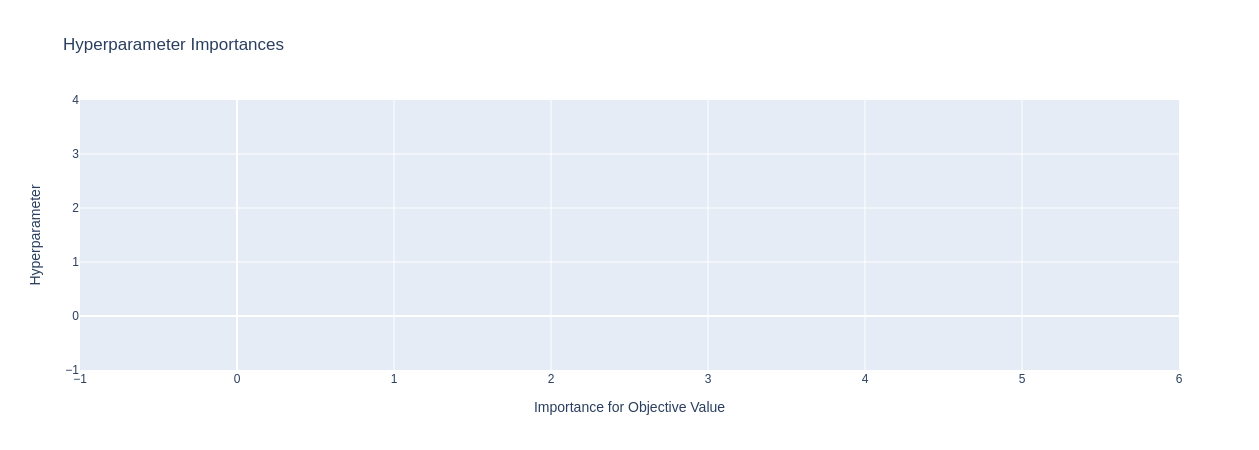

In [18]:
plot_param_importances(study)

In [13]:
import logging
import sys

import optuna

# Add stream handler of stdout to show the messages
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "example-study"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(study_name=study_name, storage=storage_name,load_if_exists=True)

[I 2021-09-28 09:17:40,606] Using an existing study with name 'example-study' instead of creating a new one.


Using an existing study with name 'example-study' instead of creating a new one.
Using an existing study with name 'example-study' instead of creating a new one.
